In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Instanciando la red pre-entrenada EfficientNetV2B0 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
conv_base  = keras.applications.efficientnet_v2.EfficientNetV2B0(
    weights="imagenet",
    include_top=False)

In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJO/Trabajos_ciencia_de_datos/Clasificacion_imagenes/Dataset_bien.zip

Ajustando los datos de la BD


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'Dataset_bien/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Dataset_bien/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Dataset_bien/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1158 files belonging to 4 classes.
Found 252 files belonging to 4 classes.
Found 287 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
conv_base.trainable = False

# conv_base.trainable = True
# for layer in conv_base.layers[:-4]:
#     layer.trainable = False

In [ ]:
conv_base.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(768, kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Fijar los hiperparámetros y entrenar la red

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=15,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/15


37/37 [==============================] - 27s 376ms/step - loss: 1943.7513 - accuracy: 0.3860 - val_loss: 1880.7811 - val_accuracy: 0.5317
Epoch 2/15
37/37 [==============================] - 13s 305ms/step - loss: 1829.3411 - accuracy: 0.4629 - val_loss: 1772.2802 - val_accuracy: 0.5794
Epoch 3/15
37/37 [==============================] - 13s 312ms/step - loss: 1721.9462 - accuracy: 0.5216 - val_loss: 1666.2147 - val_accuracy: 0.5833
Epoch 4/15
37/37 [==============================] - 13s 310ms/step - loss: 1617.0098 - accuracy: 0.5535 - val_loss: 1562.5824 - val_accuracy: 0.6587
Epoch 5/15
37/37 [==============================] - 16s 391ms/step - loss: 1514.7974 - accuracy: 0.5812 - val_loss: 1462.2430 - val_accuracy: 0.6071
Epoch 6/15
37/37 [==============================] - 13s 313ms/step - loss: 1415.7866 - accuracy: 0.5699 - val_loss: 1364.8563 - val_accuracy: 0.6746
Epoch 7/15
37/37 [==============================] - 14s 337ms/step - loss: 1319.8699 - accuracy: 0.6295 - val_loss: 1

Visualizando la pérdida y el accuracy durante el entrenamiento


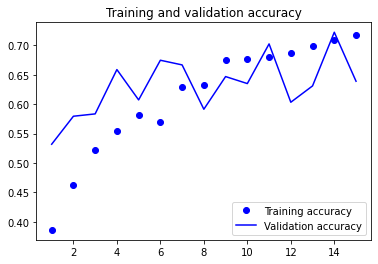

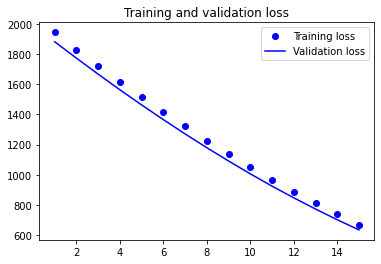

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 106ms/step - loss: 634.6074 - accuracy: 0.5784


[634.607421875, 0.5783972144126892]

Fijar los hiperparámetros y entrenar la red

In [ ]:
conv_base.trainable = True

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=2,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/2


37/37 [==============================] - 54s 410ms/step - loss: 594.7681 - accuracy: 0.4206 - val_loss: 561.8743 - val_accuracy: 0.5278
Epoch 2/2
37/37 [==============================] - 15s 358ms/step - loss: 535.4297 - accuracy: 0.5164 - val_loss: 506.6210 - val_accuracy: 0.5714


Visualizando la pérdida y el accuracy durante el entrenamiento


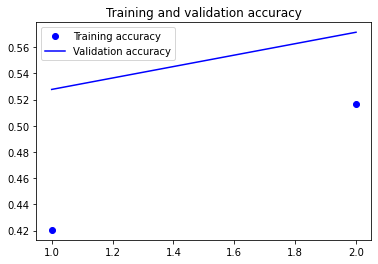

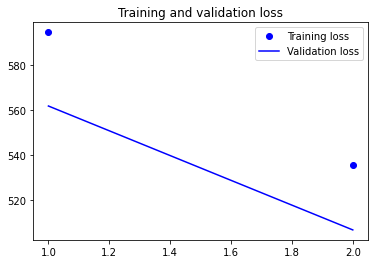

In [ ]:

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 50ms/step - loss: 506.6977 - accuracy: 0.4808


[506.6977233886719, 0.48083624243736267]

In [ ]:
conv_base.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=5,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/5


37/37 [==============================] - 24s 349ms/step - loss: 469.6416 - accuracy: 0.5147 - val_loss: 439.5928 - val_accuracy: 0.6071
Epoch 2/5
37/37 [==============================] - 13s 308ms/step - loss: 415.5980 - accuracy: 0.5458 - val_loss: 389.6584 - val_accuracy: 0.6071
Epoch 3/5
37/37 [==============================] - 13s 305ms/step - loss: 367.0220 - accuracy: 0.6123 - val_loss: 342.8948 - val_accuracy: 0.5833
Epoch 4/5
37/37 [==============================] - 13s 305ms/step - loss: 321.5759 - accuracy: 0.6416 - val_loss: 299.0964 - val_accuracy: 0.6111
Epoch 5/5
37/37 [==============================] - 13s 313ms/step - loss: 279.3301 - accuracy: 0.6330 - val_loss: 258.5051 - val_accuracy: 0.6429


Visualizando la pérdida y el accuracy durante el entrenamiento


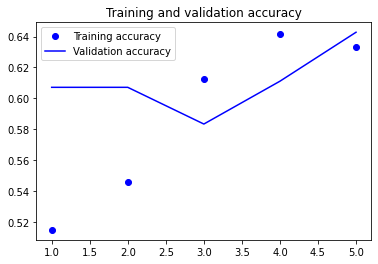

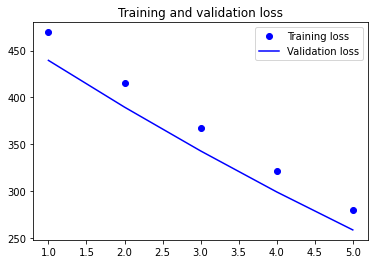

In [ ]:

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 51ms/step - loss: 258.5854 - accuracy: 0.5505


[258.5853576660156, 0.5505226254463196]

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=5,  #30
    batch_size=64,
    validation_data=validation_dataset)

Epoch 1/5


37/37 [==============================] - 24s 344ms/step - loss: 233.1960 - accuracy: 0.6278 - val_loss: 212.8573 - val_accuracy: 0.6389
Epoch 2/5
37/37 [==============================] - 15s 375ms/step - loss: 196.7462 - accuracy: 0.6537 - val_loss: 179.8779 - val_accuracy: 0.6667
Epoch 3/5
37/37 [==============================] - 13s 307ms/step - loss: 165.3012 - accuracy: 0.6839 - val_loss: 150.4154 - val_accuracy: 0.6270
Epoch 4/5
37/37 [==============================] - 13s 304ms/step - loss: 137.1923 - accuracy: 0.6917 - val_loss: 123.8425 - val_accuracy: 0.6389
Epoch 5/5
37/37 [==============================] - 13s 306ms/step - loss: 112.2484 - accuracy: 0.6926 - val_loss: 100.5644 - val_accuracy: 0.6548


Visualizando la pérdida y el accuracy durante el entrenamiento


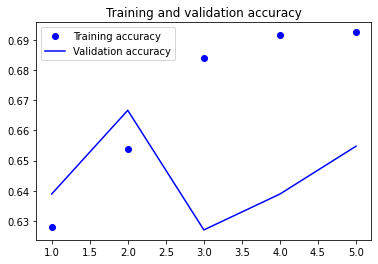

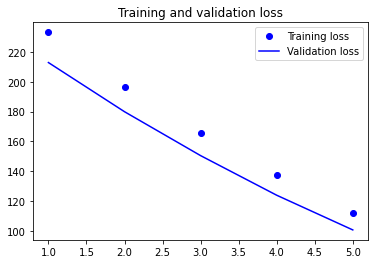

In [ ]:

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 50ms/step - loss: 100.6527 - accuracy: 0.5645


[100.65272521972656, 0.5644599199295044]

### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 2s 2s/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[167  24  12  65]
 [  8 212  51  38]
 [ 11  45 143  56]
 [ 18  39  41 228]]


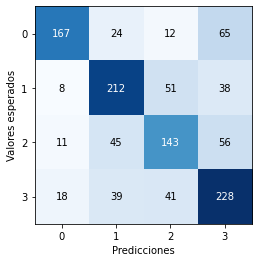

              precision    recall  f1-score   support

           0       0.82      0.62      0.71       268
           1       0.66      0.69      0.67       309
           2       0.58      0.56      0.57       255
           3       0.59      0.70      0.64       326

    accuracy                           0.65      1158
   macro avg       0.66      0.64      0.65      1158
weighted avg       0.66      0.65      0.65      1158



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 36ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[34  7  1 16]
 [ 2 52  5  9]
 [ 3 12 31  9]
 [ 3 12  8 48]]


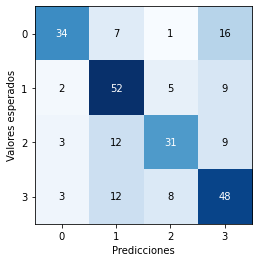

              precision    recall  f1-score   support

           0       0.81      0.59      0.68        58
           1       0.63      0.76      0.69        68
           2       0.69      0.56      0.62        55
           3       0.59      0.68      0.63        71

    accuracy                           0.65       252
   macro avg       0.68      0.65      0.65       252
weighted avg       0.67      0.65      0.65       252



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 35ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[32 10  4 20]
 [ 3 50 10 14]
 [ 3 17 26 17]
 [ 3 15  9 54]]


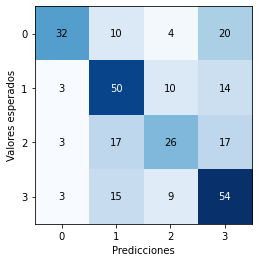

              precision    recall  f1-score   support

           0       0.78      0.48      0.60        66
           1       0.54      0.65      0.59        77
           2       0.53      0.41      0.46        63
           3       0.51      0.67      0.58        81

    accuracy                           0.56       287
   macro avg       0.59      0.55      0.56       287
weighted avg       0.59      0.56      0.56       287



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow
# Convert the model.
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_EfficientNetV2B0.tflite', 'wb') as f:
  f.write(tflite_model)